In [1]:
import torch 
import numpy as np
import pandas as pd 
from math import ceil
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


In [2]:
# Import necessary libraries and modules
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import joblib
import matplotlib.dates as mdates

In [3]:
import pandas as pd
import yfinance as yf

# Load your existing CSV file
input_file = 'Datasets/sp500_sentiment_non_weighted.csv'
output_file = 'Datasets/sp500_sentiment_updated.csv'
data = pd.read_csv(input_file)

# Convert the 'date' column in your existing data to datetime format and remove any timezone info
data['date'] = pd.to_datetime(data['date']).dt.tz_localize(None)

# Download S&P 500 data for the given timeframe
sp500 = yf.download("^GSPC", start="2010-01-01", end="2021-01-01")

# Flatten the MultiIndex columns in `sp500`
sp500.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in sp500.columns]

# Reset index to make 'Date' a column and rename it to 'date'
sp500.reset_index(inplace=True)
sp500.rename(columns={'Date': 'date'}, inplace=True)


# Select only the required columns
sp500 = sp500[['date', 'Low_^GSPC', 'High_^GSPC', 'Adj Close_^GSPC', 'Open_^GSPC']]
sp500.rename(columns={'Low_^GSPC': 'Low', 'High_^GSPC': 'High', 'Adj Close_^GSPC': 'Adj Close','Open_^GSPC': 'Open'}, inplace=True)

# Convert 'date' column in sp500 to datetime and remove timezone info
sp500['date'] = pd.to_datetime(sp500['date']).dt.tz_localize(None)

# Merge the financial data with the existing data
merged_data = pd.merge(data, sp500, on='date', how='left')

# Save the updated data to a new CSV file
merged_data.to_csv(output_file, index=False)
print(f"Updated data with 'Low', 'High', and 'Adj Close' saved to {output_file}")


[*********************100%***********************]  1 of 1 completed

Updated data with 'Low', 'High', and 'Adj Close' saved to Datasets/sp500_sentiment_updated.csv


In [4]:
data = pd.read_csv("Datasets/sp500_sentiment_updated.csv")
data

,Unnamed: 0,date,Volume,Close,Positive,Negative,Neutral,Price_change,Low,High,Adj Close,Open
0,0,2010-01-05,1.141819e+07,1136.520020,0.275458,0.357004,0.367538,1,1129.660034,1136.630005,1136.520020,1132.660034
1,1,2010-01-06,1.078500e+07,1137.140015,0.292846,0.177264,0.529890,1,1133.949951,1139.189941,1137.140015,1135.709961
2,2,2010-01-07,1.202273e+07,1141.689941,0.418571,0.011353,0.570076,1,1131.319946,1142.459961,1141.689941,1136.270020
3,3,2010-01-08,1.621044e+07,1144.979980,0.075816,0.252077,0.672107,1,1136.219971,1145.390015,1144.979980,1140.520020
4,4,2010-01-11,1.167700e+07,1146.979980,0.602344,0.010513,0.387143,1,1142.020020,1149.739990,1146.979980,1145.959961
...,...,...,...,...,...,...,...,...,...,...,...,...
2612,2612,2020-06-05,3.789298e+07,3193.929932,0.507138,0.087936,0.404926,1,3163.840088,3211.719971,3193.929932,3163.840088
2613,2613,2020-06-08,5.888138e+07,3232.389893,0.510386,0.121527,0.368087,1,3196.000000,3233.129883,3232.389893,3199.919922
2614,2614,2020-06-09,6.799510e+07,3207.179932,0.322274,0.249364,0.428363,-1,3193.110107,3222.709961,3207.179932,3213.320068
2615,2615,2020-06-10,8.681144e+07,3190.139893,0.418343,0.205621,0.376035,-1,3181.489990,3223.270020,3190.139893,3213.419922


In [5]:
data.dtypes

Unnamed: 0        int64
date             object
Volume          float64
Close           float64
Positive        float64
Negative        float64
Neutral         float64
Price_change      int64
Low             float64
High            float64
Adj Close       float64
Open            float64
dtype: object

In [6]:
# Convert date column to a valid Datetime format
data["date"] = pd.to_datetime(data["date"])

# Check column types
data.dtypes

Unnamed: 0               int64
date            datetime64[ns]
Volume                 float64
Close                  float64
Positive               float64
Negative               float64
Neutral                float64
Price_change             int64
Low                    float64
High                   float64
Adj Close              float64
Open                   float64
dtype: object

In [7]:
# Define selected features and target attribute
features = ["Open", "High", "Low",	"Close", "Adj Close", "Volume","Positive","Negative","Neutral","Price_change"]
target = "Open"

In [8]:
# Define start and end time for each period
train_start_date = pd.to_datetime("2015-01-01")
train_end_date = pd.to_datetime("2018-12-31")
validate_start_date = pd.to_datetime("2019-01-01")
validate_end_date = pd.to_datetime("2020-01-31")
test_start_date = pd.to_datetime("2020-02-01")
test_end_date = pd.to_datetime("2020-06-11")

# Split dataset into training, validation, and testing
data_train = data[(data["date"] >= train_start_date) & (data["date"] <= train_end_date)][features]
data_train_dates = data[(data["date"] >= train_start_date) & (data["date"] <= train_end_date)]["date"]
data_validate = data[(data["date"] >= validate_start_date) & (data["date"] <= validate_end_date)][features]
data_validate_dates = data[(data["date"] >= validate_start_date) & (data["date"] <= validate_end_date)]["date"]
data_test = data[(data["date"] >= test_start_date) & (data["date"] <= test_end_date)][features]
data_test_dates = data[(data["date"] >= test_start_date) & (data["date"] <= test_end_date)]["date"]

In [9]:
# Display the shape of each dataset
print(f"Training Set: {data_train.shape}")
print(f"Validation Set: {data_validate.shape}")
print(f"Testing Set: {data_test.shape}")

Training Set: (1006, 10)
Validation Set: (273, 10)
Testing Set: (91, 10)


In [10]:
# Display a summary of each dataset
print("Training Dataset:")
print(data_train.head())
print("Validation Dataset:")
print(data_validate.head())
print("Testing Dataset:")
print(data_test.head())

Training Dataset:
             Open         High          Low        Close    Adj Close  \
1247  2058.899902  2072.360107  2046.040039  2058.199951  2058.199951   
1248  2054.439941  2054.439941  2017.339966  2020.579956  2020.579956   
1249  2022.150024  2030.250000  1992.439941  2002.609985  2002.609985   
1250  2005.550049  2029.609985  2005.550049  2025.900024  2025.900024   
1251  2030.609985  2064.080078  2030.609985  2062.139893  2062.139893   

            Volume  Positive  Negative   Neutral  Price_change  
1247  6.448280e+06  0.301385  0.086695  0.611920            -1  
1248  6.008914e+07  0.657178  0.041321  0.301501            -1  
1249  4.643910e+07  0.112840  0.188709  0.698451            -1  
1250  7.155600e+06  0.310706  0.046675  0.642619             1  
1251  1.480449e+07  0.208420  0.289509  0.502071             1  
Validation Dataset:
             Open         High          Low        Close    Adj Close  \
2253  2476.959961  2519.489990  2467.469971  2510.030029  25

In [11]:
import matplotlib.pyplot as plt


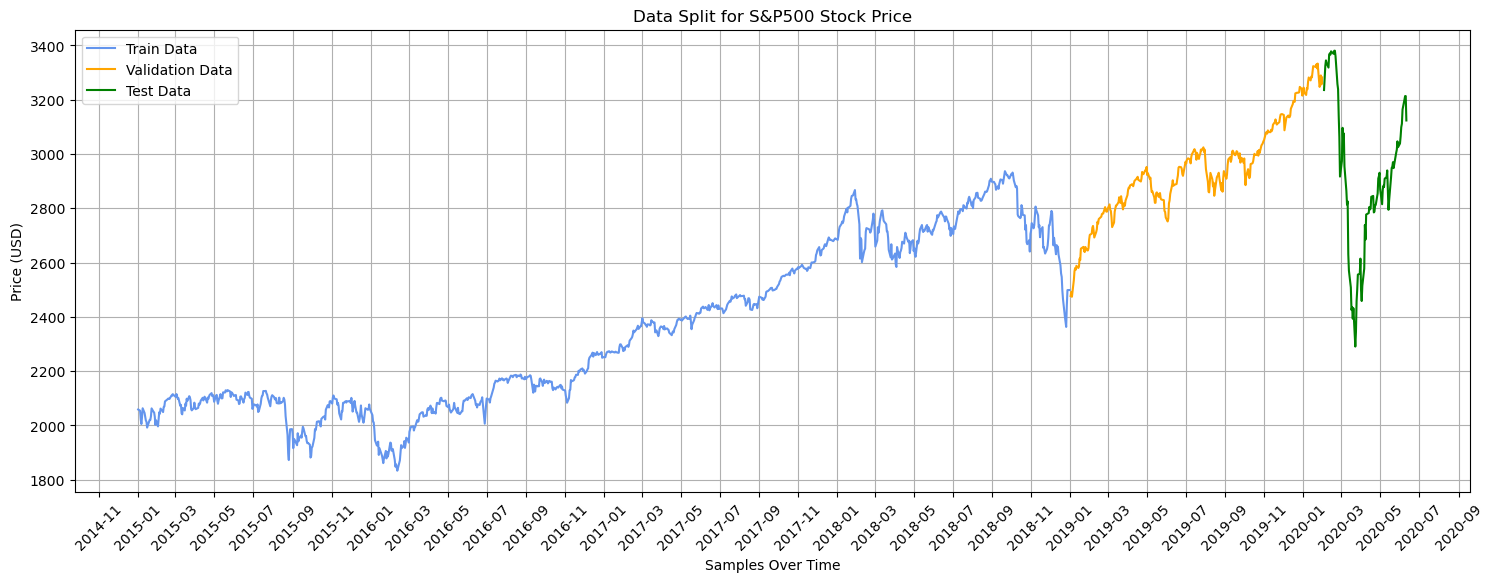

In [12]:
# Plot stock prices for each data split
plt.figure(figsize=(18,6))
plt.plot(data_train_dates, data_train["Open"], color="cornflowerblue")
plt.plot(data_validate_dates, data_validate["Open"], color="orange")
plt.plot(data_test_dates, data_test["Open"], color="green")
plt.legend(["Train Data", "Validation Data", "Test Data"])
plt.title("Data Split for S&P500 Stock Price")
plt.xlabel("Samples Over Time")
plt.ylabel("Price (USD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)
plt.grid()

In [13]:
data[features].describe()

,Open,High,Low,Close,Adj Close,Volume,Positive,Negative,Neutral,Price_change
count,2617.000000,2617.000000,2617.000000,2617.000000,2617.000000,2.617000e+03,2617.000000,2617.000000,2617.000000,2617.000000
mean,2007.895731,2017.938651,1996.940471,2008.283040,2008.283040,4.550004e+07,0.267443,0.170883,0.561674,0.096676
std,615.260307,617.352782,612.772132,615.080920,615.080920,6.221001e+07,0.134483,0.120418,0.156393,0.995506
min,1027.650024,1032.949951,1010.909973,1022.580017,1022.580017,9.112000e+03,0.009232,0.008018,0.021417,-1.000000
25%,1402.550049,1407.140015,1395.729980,1402.599976,1402.599976,1.084958e+07,0.174338,0.084126,0.466801,-1.000000
50%,2018.979980,2029.609985,2005.550049,2019.640015,2019.640015,2.120185e+07,0.256537,0.149092,0.558363,1.000000
75%,2530.340088,2552.510010,2503.189941,2531.939941,2531.939941,6.033775e+07,0.342711,0.229808,0.661855,1.000000
max,3380.449951,3393.520020,3378.830078,3386.149902,3386.149902,1.278744e+09,0.945985,0.969351,0.949079,1.000000


In [14]:
from sklearn.preprocessing import MinMaxScaler


In [15]:
# Initialize scaler with range [0,1]
sc = MinMaxScaler(feature_range=(0,1))

# Fit and transform scaler to training set
data_train_scaled = sc.fit_transform(data_train)

# Transform validating and testing datasets
data_validate_scaled = sc.transform(data_validate)
data_test_scaled = sc.transform(data_test)

In [16]:
import joblib


In [17]:
# Prepare scaler model name and location
scaler_model_location = "models/"
scaler_model_name = "sp500_stock_price_scaler"
scaler_model_ext = "gz"

# Store scaler model
joblib.dump(sc, scaler_model_location + scaler_model_name + "." + scaler_model_ext)

['models/sp500_stock_price_scaler.gz']

In [18]:
# Combine dates with each corresponding dataset
data_train_scaled_final = pd.DataFrame(data_train_scaled, columns=features, index=None)
data_train_scaled_final["Date"] = data_train_dates.values

data_validate_scaled_final = pd.DataFrame(data_validate_scaled, columns=features, index=None)
data_validate_scaled_final["Date"] = data_validate_dates.values

data_test_scaled_final = pd.DataFrame(data_test_scaled, columns=features, index=None)
data_test_scaled_final["Date"] = data_test_dates.values

In [19]:
# Prepare datasets files and location
data_file_location = "Datasets/"
data_file_name_train = "sp500_stock_price_processed_train"
data_file_name_validate = "sp500_stock_price_processed_validate"
data_file_name_test = "sp500_stock_price_processed_test"
data_file_ext = "csv"

# Store datasets
data_train_scaled_final.to_csv(data_file_location + data_file_name_train + "." + data_file_ext, index=None)
data_validate_scaled_final.to_csv(data_file_location + data_file_name_validate + "." + data_file_ext, index=None)
data_test_scaled_final.to_csv(data_file_location + data_file_name_test + "." + data_file_ext, index=None)

In [20]:
# Import necessary libraries and modules
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
import joblib
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [21]:
# Prepare datasets files and location
data_file_location = "Datasets/"
data_file_name_train = "sp500_stock_price_processed_train"
data_file_name_validate = "sp500_stock_price_processed_validate"
data_file_name_test = "sp500_stock_price_processed_test"
data_file_ext = "csv"

# Store datasets
data_train_df = pd.read_csv(data_file_location + data_file_name_train + "." + data_file_ext)
data_validate_df = pd.read_csv(data_file_location + data_file_name_validate + "." + data_file_ext)
data_test_df = pd.read_csv(data_file_location + data_file_name_test + "." + data_file_ext)

In [22]:
# Check loaded datasets shape
print(f"Training Dataset Shape: {data_train_df.shape}")
print(f"Validation Dataset Shape: {data_validate_df.shape}")
print(f"Testing Dataset Shape: {data_test_df.shape}")

Training Dataset Shape: (1006, 11)
Validation Dataset Shape: (273, 11)
Testing Dataset Shape: (91, 11)


In [23]:
# Display a summary of each dataset
print("Training Dataset:")
print(data_train_df.head())
print("Validation Dataset:")
print(data_validate_df.head())
print("Testing Dataset:")
print(data_test_df.head())

Training Dataset:
       Open      High       Low     Close  Adj Close    Volume  Positive  \
0  0.204376  0.206013  0.211225  0.207975   0.207975  0.011957  0.342071   
1  0.200333  0.189632  0.185531  0.173827   0.173827  0.166331  0.793515   
2  0.171068  0.167518  0.163239  0.157515   0.157515  0.127047  0.102838   
3  0.156023  0.166933  0.174976  0.178656   0.178656  0.013992  0.353897   
4  0.178736  0.198444  0.197411  0.211551   0.211551  0.036005  0.224114   

   Negative   Neutral  Price_change        Date  
0  0.104980  0.640550           0.0  2015-01-02  
1  0.041441  0.292089           0.0  2015-01-05  
2  0.247835  0.737685           0.0  2015-01-06  
3  0.048938  0.675012           1.0  2015-01-07  
4  0.388988  0.517239           1.0  2015-01-08  
Validation Dataset:
       Open      High       Low     Close  Adj Close    Volume  Positive  \
0  0.583273  0.614758  0.588509  0.618107   0.618107  0.139825  0.203491   
1  0.596831  0.590670  0.567461  0.561702   0.561702 

In [24]:
# Convert Date column to a valid Datetime format
data_train_df["Date"] = pd.to_datetime(data_train_df["Date"])
data_validate_df["Date"] = pd.to_datetime(data_validate_df["Date"])
data_test_df["Date"] = pd.to_datetime(data_test_df["Date"])

In [25]:
# Extract dates from each dataset
data_train_dates = data_train_df["Date"]
data_validate_dates = data_validate_df["Date"]
data_test_dates = data_test_df["Date"]

In [26]:
# Extract features
features = ["Open", "High", "Low",	"Close", "Adj Close", "Volume","Positive","Negative","Neutral","Price_change"]
data_train_scaled = data_train_df[features].values
data_validate_scaled = data_validate_df[features].values
data_test_scaled = data_test_df[features].values

In [27]:
# Define a method to construct the input data X and Y
def construct_lstm_data(data, sequence_size, target_attr_idx):
    """
    Construct input data (X) and target data (y) for LSTM model from a pandas DataFrame.

    Parameters:
    -----------
    data : numpy.ndarray
        Input data array of shape (n_samples, n_features).
    
    sequence_size : int
        Number of previous time steps to use as input features for predicting the next time step.
    
    target_attr_idx : int
        Index of column in `data` DataFrame that corresponds to target attribute that LSTM model will predict.

    Returns:
    --------
    data_X : numpy.ndarray
        Array of LSTM input sequences of shape (n_samples - sequence_size, sequence_size, n_features).

    data_y : numpy.ndarray
        Corresponding target values for each input sequence of shape (n_samples - sequence_size,).
    """
    
    # Initialize constructed data variables
    data_X = []
    data_y = []
    
    # Iterate over the dataset
    for i in range(sequence_size, len(data)):
        data_X.append(data[i-sequence_size:i,0:data.shape[1]])
        data_y.append(data[i,target_attr_idx])
        
    # Return constructed variables
    return np.array(data_X), np.array(data_y)

In [28]:
# Define the sequence size
sequence_size = 60

# Construct training data
X_train, y_train = construct_lstm_data(data_train_scaled, sequence_size, 0)

In [29]:
# Combine scaled datasets all together
data_all_scaled = np.concatenate([data_train_scaled, data_validate_scaled, data_test_scaled], axis=0)

# Calculate data size
train_size = len(data_train_scaled)
validate_size = len(data_validate_scaled)
test_size = len(data_test_scaled)

# Construct validation dataset
X_validate, y_validate = construct_lstm_data(data_all_scaled[train_size-sequence_size:train_size+validate_size,:], sequence_size, 0)

# Construct testing dataset
X_test, y_test = construct_lstm_data(data_all_scaled[-(test_size+sequence_size):,:], sequence_size, 0)

In [30]:
# Check original data and data splits shapes
print(f"Full Scaled Data: {data_all_scaled.shape}")
print(f"\n Data Train Scaled: {data_train_scaled.shape}")
print(f"> Data Train X: {X_train.shape}")
print(f"> Data Train y: {y_train.shape}")

print(f"\n Data Validate Scaled: {data_validate_scaled.shape}")
print(f"> Data Validate X: {X_validate.shape}")
print(f"> Data Validate y: {y_validate.shape}")

print(f"\n Data Test Scaled: {data_test_scaled.shape}")
print(f"> Data Test X: {X_test.shape}")
print(f"> Data Test y: {y_test.shape}")

Full Scaled Data: (1370, 10)

 Data Train Scaled: (1006, 10)
> Data Train X: (946, 60, 10)
> Data Train y: (946,)

 Data Validate Scaled: (273, 10)
> Data Validate X: (273, 60, 10)
> Data Validate y: (273,)

 Data Test Scaled: (91, 10)
> Data Test X: (91, 60, 10)
> Data Test y: (91,)


In [31]:
# Initializing the model
regressor = Sequential()

In [32]:
# Add input layer
regressor.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

In [33]:
# Add first LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

In [34]:
# Add second LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

In [35]:
# Add third LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

In [36]:
# Add forth LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100))
regressor.add(Dropout(rate = 0.2))

In [37]:
# Add last dense layer/output layer
regressor.add(Dense(units = 1))

In [38]:
# Compiling the model
regressor.compile(optimizer = "adam", loss="mean_squared_error")

In [39]:
import os

model_location = "models/"
if not os.path.exists(model_location):
    os.makedirs(model_location)


In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

# Test ModelCheckpoint
try:
    test_callback = ModelCheckpoint("test_model.keras")
    print("ModelCheckpoint imported successfully.")
except Exception as e:
    print("Error with ModelCheckpoint:", e)

# Test load_model
try:
    # This will fail if there’s no model yet, but you’ll see if the function is available
    model = load_model("test_model.keras")
    print("load_model imported successfully.")
except Exception as e:
    print("load_model function is available, but no model to load:", e)


ModelCheckpoint imported successfully.
load_model function is available, but no model to load: File not found: filepath=test_model.keras. Please ensure the file is an accessible `.keras` zip file.


In [41]:
# Create a checkpoint to monitor the validation loss and save the model with the best performance.
model_location = "models/"
model_name = "sp500_stock_price_lstm.model.keras"
best_model_checkpoint_callback = ModelCheckpoint(
    model_location + model_name, 
    monitor="val_loss", 
    save_best_only=True, 
    mode="min", 
    verbose=0)


In [42]:
# Training the model
history = regressor.fit(
    x = X_train, 
    y = y_train, 
    validation_data=(X_validate, y_validate), 
    epochs=200, 
    batch_size = 64, 
    callbacks = [best_model_checkpoint_callback])

Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 295ms/step - loss: 0.1168 - val_loss: 0.0415
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - loss: 0.0099 - val_loss: 0.0189
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - loss: 0.0050 - val_loss: 0.0143
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - loss: 0.0035 - val_loss: 0.0120
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - loss: 0.0052 - val_loss: 0.0074
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - loss: 0.0037 - val_loss: 0.0123
Epoch 8/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step - loss: 0.0035 - val_loss: 0.0086
Epoch 9/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 10/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 11/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 12/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 

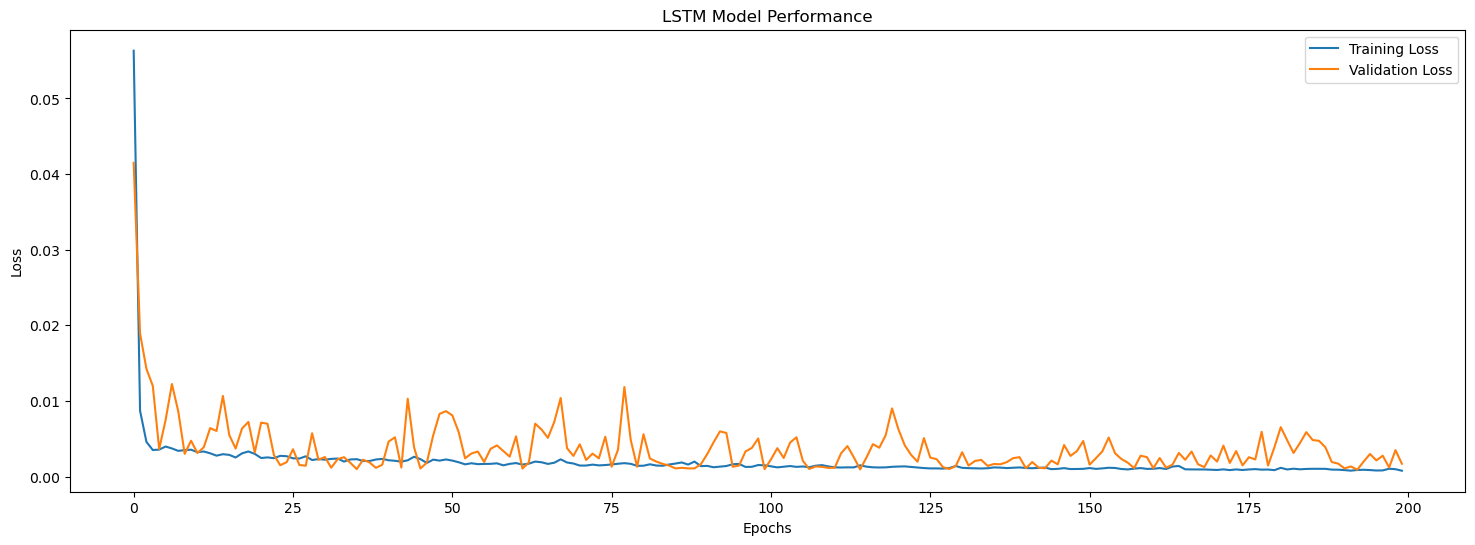

In [43]:
# Visualizing model performance during training
plt.figure(figsize=(18, 6))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.title("LSTM Model Performance")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [44]:
# Prepare model location and name
model_location = "models/"
model_name = "sp500_stock_price_lstm.model.keras"

# Load the best performing model
best_model = load_model(model_location + model_name)

In [45]:
# Predict stock price for all data splits
y_train_predict = best_model.predict(X_train)
y_validate_predict = best_model.predict(X_validate)
y_test_predict = best_model.predict(X_test)

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [46]:
# Prepare scaler model name and location
scaler_model_location = "models/"
scaler_model_name = "sp500_stock_price_scaler"
scaler_model_ext = "gz"

# Store the scaler model
sc = joblib.load(scaler_model_location + scaler_model_name + "." + scaler_model_ext)

In [47]:
y_train_inv = sc.inverse_transform(np.concatenate((y_train.reshape(-1, 1), np.ones((len(y_train.reshape(-1, 1)), 9))), axis=1))[:, 0]
y_validate_inv = sc.inverse_transform(np.concatenate((y_validate.reshape(-1, 1), np.ones((len(y_validate.reshape(-1, 1)), 9))), axis=1))[:, 0]
y_test_inv = sc.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.ones((len(y_test.reshape(-1, 1)), 9))), axis=1))[:, 0]

y_train_predict_inv = sc.inverse_transform(np.concatenate((y_train_predict, np.ones((len(y_train_predict), 9))), axis=1))[:, 0]
y_validate_predict_inv = sc.inverse_transform(np.concatenate((y_validate_predict, np.ones((len(y_validate_predict), 9))), axis=1))[:, 0]
y_test_predict_inv = sc.inverse_transform(np.concatenate((y_test_predict, np.ones((len(y_test_predict), 9))), axis=1))[:, 0]


In [48]:
# Define chart colors
train_actual_color = "cornflowerblue"
validate_actual_color = "orange"
test_actual_color = "green"
train_predicted_color = "lightblue"
validate_predicted_color = "peru"
test_predicted_color = "limegreen"

In [1]:
# Plot actual and predicted price
plt.figure(figsize=(18,6))
plt.plot(data_train_dates[sequence_size:,], y_train_inv, label="Training Data", color=train_actual_color)
plt.plot(data_train_dates[sequence_size:,], y_train_predict_inv, label="Training Predictions", linewidth=1, color=train_predicted_color)

plt.plot(data_validate_dates, y_validate_inv, label="Validation Data", color=validate_actual_color)
plt.plot(data_validate_dates, y_validate_predict_inv, label="Validation Predictions", linewidth=1, color=validate_predicted_color)

plt.plot(data_test_dates, y_test_inv, label="Testing Data", color=test_actual_color)
plt.plot(data_test_dates, y_test_predict_inv, label="Testing Predictions", linewidth=1, color=test_predicted_color)

plt.title("SP500 Stock Price Predictions With LSTM")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)
plt.legend()
plt.grid(color="lightgray")

NameError: name 'plt' is not defined

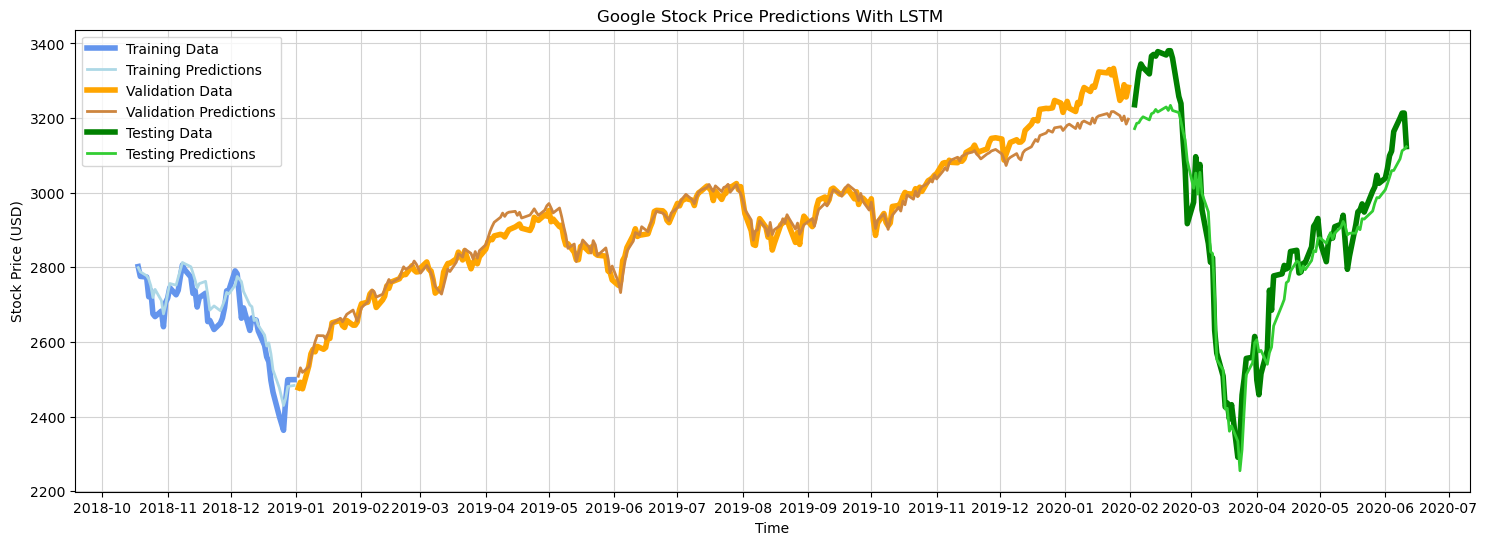

In [57]:
recent_samples = 50
plt.figure(figsize=(18,6))
plt.plot(data_train_dates[-recent_samples:,], y_train_inv[-recent_samples:,], label="Training Data", color=train_actual_color, linewidth=4)
plt.plot(data_train_dates[-recent_samples:,], y_train_predict_inv[-recent_samples:,], label="Training Predictions", linewidth=2, color=train_predicted_color)

plt.plot(data_validate_dates, y_validate_inv, label="Validation Data", color=validate_actual_color, linewidth=4)
plt.plot(data_validate_dates, y_validate_predict_inv, label="Validation Predictions", linewidth=2, color=validate_predicted_color)

plt.plot(data_test_dates, y_test_inv, label="Testing Data", color=test_actual_color, linewidth=4)
plt.plot(data_test_dates, y_test_predict_inv, label="Testing Predictions", linewidth=2, color=test_predicted_color)

plt.title("Google Stock Price Predictions With LSTM ")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# plt.xticks(rotation=45)
plt.legend()
plt.grid(color="lightgray")

In [51]:

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate Mean Squared Error (MSE) and Mean Absolute Error (MAE) for test data
mse = mean_squared_error(y_test_inv, y_test_predict_inv)
mae = mean_absolute_error(y_test_inv, y_test_predict_inv)

print("Mean Square Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)


Mean Square Error (MSE): 6437.2514676083265
Mean Absolute Error (MAE): 64.65386874882351


In [52]:

import pandas as pd

# Adjust the dates to match the length of the actual and predicted values, assuming the predictions are shorter due to LSTM sequence requirements.
# The following code trims the date ranges to match the lengths of `y_train_inv`, `y_validate_inv`, and `y_test_inv`.

# Adjust training dates
adjusted_train_dates = data_train_dates[-len(y_train_inv):]

# Adjust validation dates
adjusted_validate_dates = data_validate_dates[-len(y_validate_inv):]

# Adjust test dates
adjusted_test_dates = data_test_dates[-len(y_test_inv):]

# Create side-by-side comparison DataFrames
comparison_train = pd.DataFrame({
    'Date': adjusted_train_dates,
    'Actual Value': y_train_inv.flatten(),
    'Predicted Value': y_train_predict_inv.flatten()
})

comparison_validate = pd.DataFrame({
    'Date': adjusted_validate_dates,
    'Actual Value': y_validate_inv.flatten(),
    'Predicted Value': y_validate_predict_inv.flatten()
})

comparison_test = pd.DataFrame({
    'Date': adjusted_test_dates,
    'Actual Value': y_test_inv.flatten(),
    'Predicted Value': y_test_predict_inv.flatten()
})

# Display the comparison DataFrames
print("Training Set Comparison (Last 5 Records):")
print(comparison_train)

print("\nValidation Set Comparison (Last 5 Records):")
print(comparison_validate)

print("\nTest Set Comparison (Last 5 Records):")
print(comparison_test)


Training Set Comparison (Last 5 Records):
           Date  Actual Value  Predicted Value
60   2015-03-31   2084.050049      2086.088650
61   2015-04-01   2067.629883      2084.881757
62   2015-04-02   2060.030029      2063.846322
63   2015-04-06   2064.870117      2061.040179
64   2015-04-07   2080.790039      2073.164602
...         ...           ...              ...
1001 2018-12-24   2400.560059      2477.046061
1002 2018-12-26   2363.120117      2429.680256
1003 2018-12-27   2442.500000      2448.338421
1004 2018-12-28   2498.770020      2480.561550
1005 2018-12-31   2498.939941      2483.358880

[946 rows x 3 columns]

Validation Set Comparison (Last 5 Records):
          Date  Actual Value  Predicted Value
0   2019-01-02   2476.959961      2508.139275
1   2019-01-03   2491.919922      2530.582369
2   2019-01-04   2474.330078      2518.387166
3   2019-01-07   2535.610107      2533.269805
4   2019-01-08   2568.110107      2558.356404
..         ...           ...              ...
268

In [53]:
import pandas as pd
from scipy.stats import spearmanr, pearsonr

In [54]:
actual_values = comparison_test['Actual Value']
predicted_values = comparison_test['Predicted Value']

In [55]:
spearman_corr, spearman_p_value = spearmanr(actual_values, predicted_values)
print(f"Spearman Correlation: {spearman_corr}")
print(f"Spearman p-value: {spearman_p_value}")

Spearman Correlation: 0.977942347507565
Spearman p-value: 2.543251752341885e-62


In [56]:
pearson_corr, pearson_p_value = pearsonr(actual_values, predicted_values)
print(f"Pearson Correlation: {pearson_corr}")
print(f"Pearson p-value: {pearson_p_value}")

Pearson Correlation: 0.9702023036702234
Pearson p-value: 1.398707808329054e-56
